In [55]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.colors as mcolors


In [58]:
def get_team_logo(team_abbr):
    current_dir = os.getcwd()
    logo_dir = os.path.join(current_dir,'logos')
    file_path = os.path.join(logo_dir,team_abbr+'.png')
    return file_path

def interpolate_color(low_color, high_color, val, min_val, max_val):
    fraction = (val - min_val) / (max_val - min_val)
    low_color_rgba = np.array(mcolors.to_rgba(low_color))
    high_color_rgba = np.array(mcolors.to_rgba(high_color))
    color = low_color_rgba * (1 - fraction) + high_color_rgba * fraction
    return mcolors.to_hex(color)


In [23]:
file_path = '2023/plots/stats'
csv_files = [f for f in os.listdir(file_path) if f.endswith('.csv')]

dataframes = {}

for csv in csv_files:
    full_path = os.path.join(file_path, csv)
    df_name = os.path.splitext(csv)[0]  
    dataframes[df_name] = pd.read_csv(full_path)
    print(f"Loaded {df_name} with {len(dataframes[df_name])} rows")

Loaded kick_df1 with 50 rows
Loaded output with 32 rows
Loaded passing_df with 32 rows
Loaded passing_of with 32 rows
Loaded pass_df with 100 rows
Loaded rec_df with 100 rows
Loaded rec_rec_per_gp_df with 100 rows
Loaded rushing_df with 32 rows
Loaded rushing_of with 32 rows
Loaded rush_df with 100 rows
Loaded rush_yd_per_gp_df with 100 rows
Loaded score_df with 150 rows


In [24]:
passing_def = dataframes['passing_df']

In [25]:
passing_def.head()

,Team,Att,Cmp,Cmp %,Yds/Att,Yds,TD,INT,Rate,1st,1st%,20+,40+,Lng,Sck
0,ARI,506,347,68.6,7.6,3846,32,11,102.9,198,39.1,49,10,63T,33
1,ATL,549,340,61.9,6.8,3707,24,8,90.3,183,33.3,49,6,61T,42
2,BAL,634,384,60.6,5.9,3717,18,18,74.6,175,27.6,46,6,71T,60
3,BUF,552,363,65.8,6.7,3676,18,18,81.9,183,33.2,44,1,48,54
4,CAR,481,309,64.2,6.5,3109,19,8,88.8,162,33.7,39,9,75T,27


In [26]:
rushing_def = dataframes['rushing_df']

In [27]:
rushing_def.head()

,Team,Att,Rush Yds,YPC,TD,20+,40+,Lng,Rush 1st,Rush 1st%,Rush FUM
0,ARI,521,2434,4.7,19,12,1,56,141,27.1,4
1,ATL,499,2009,4.0,11,14,0,38,105,21.0,9
2,BAL,415,1860,4.5,6,10,3,63,96,23.1,4
3,BUF,409,1880,4.6,14,13,2,83,96,23.5,4
4,CAR,508,2081,4.1,25,12,3,62T,122,24.0,4


In [28]:
total_defense = pd.merge(passing_def, rushing_def, on='Team')


In [29]:
total_defense.columns

Index(['Team', 'Att_x', 'Cmp', 'Cmp %', 'Yds/Att', 'Yds', 'TD_x', 'INT',
       'Rate', '1st', '1st%', '20+_x', '40+_x', 'Lng_x', 'Sck', 'Att_y',
       'Rush Yds', 'YPC', 'TD_y', '20+_y', '40+_y', 'Lng_y', 'Rush 1st',
       'Rush 1st%', 'Rush FUM'],
      dtype='object')

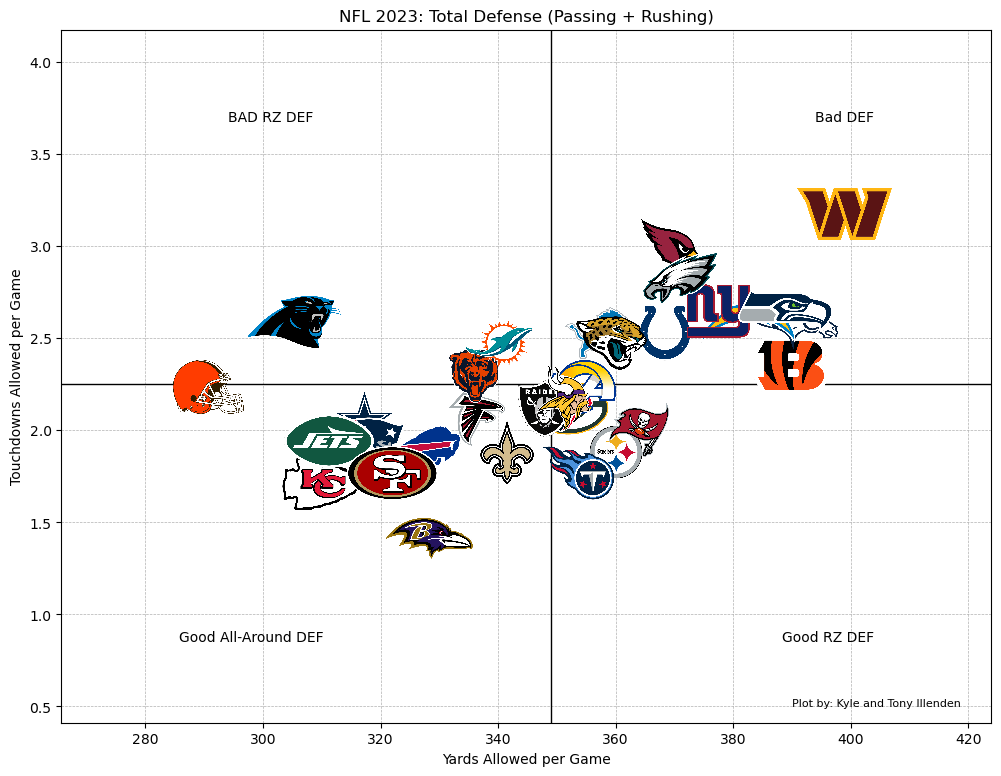

In [166]:
total_defense['TYDS/G'] = (total_defense['Yds'].astype('float') + total_defense['Rush Yds'].astype('float')) / 17
total_defense['TDs/G'] = (total_defense['TD_x'].astype('float') + total_defense['TD_y'].astype('float')) / 17

fig, ax = plt.subplots(figsize=(12, 9))

zoom = 0.05

for i, team in enumerate(total_defense['Team']):
    logo_url = get_team_logo(team)
    img = plt.imread(logo_url)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (total_defense['TYDS/G'][i], total_defense['TDs/G'][i]), frameon=False)
    ax.add_artist(ab)

x_mean = total_defense['TYDS/G'].mean()
y_mean = total_defense['TDs/G'].mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)
ax.text(x_mean + 55, total_defense['TDs/G'].max() + 0.5, 'Bad DEF', color='black', horizontalalignment='right')
ax.text(x_mean - 55, total_defense['TDs/G'].max() + 0.5, 'BAD RZ DEF', color='black', horizontalalignment='left')
ax.text(total_defense['TYDS/G'].min() - 5, total_defense['TDs/G'].min() - 0.5, 'Good All-Around DEF', color='black', horizontalalignment='left', verticalalignment='top')
ax.text(total_defense['TYDS/G'].max() + 5, total_defense['TDs/G'].min() - 0.5, 'Good RZ DEF', color='black', verticalalignment='top', horizontalalignment='right')

ax.set_xlabel('Yards Allowed per Game')
ax.set_ylabel('Touchdowns Allowed per Game')
ax.set_title('NFL 2023: Total Defense (Passing + Rushing)')
ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')
plt.xlim(total_defense['TYDS/G'].min() - 25, total_defense['TYDS/G'].max() + 25)
plt.ylim(total_defense['TDs/G'].min() - 1, total_defense['TDs/G'].max() + 1)
#plt.savefig('logos.png', dpi=450)
ax.text(390, 0.5, 'Plot by: Kyle and Tony Illenden', color='black', fontsize=8)
plt.show()

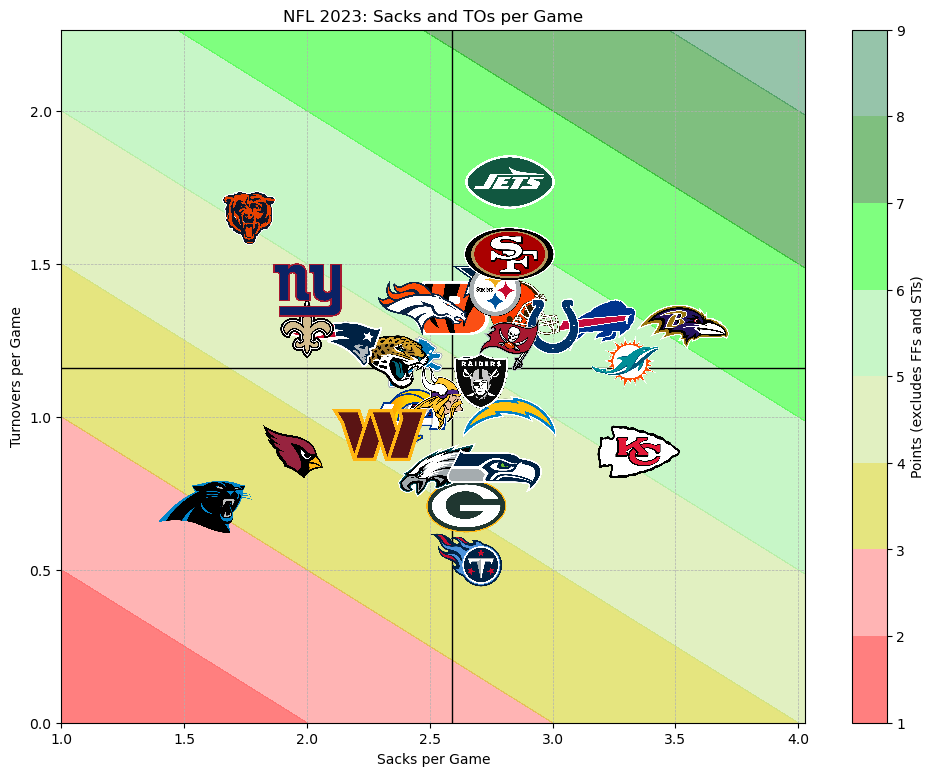

In [121]:
total_defense['TOs/G'] = (total_defense['INT'].astype('float') + total_defense['Rush FUM'].astype('float')) / 17
total_defense['Sck/G'] = total_defense['Sck'].astype('float') / 17

x = np.linspace(total_defense['Sck/G'].min() - 1, total_defense['Sck/G'].max() + 1, 100)
y = np.linspace(total_defense['TOs/G'].min() - 1, total_defense['TOs/G'].max() + 1, 100)
X, Y = np.meshgrid(x, y)
Z = 2 * Y + X

colors = [
    "#FF0000",  # Pure Red
    "#FF6B6B",  # Light Red
    "#CCCC00",  # Olive Yellow
    "#C5E384",  # Gold (Variant of Yellow, kept for comparison)
    "#90EE90",  # Light Green
    "#00FF00", 
    "#008000",
    "seagreen" 
]

fig, ax = plt.subplots(figsize=(12, 9))

zoom = 0.05

for i, team in enumerate(total_defense['Team']):
    logo_url = get_team_logo(team)
    img = plt.imread(logo_url)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (total_defense['Sck/G'][i], total_defense['TOs/G'][i]), frameon=False)
    ax.add_artist(ab)

x_mean = total_defense['Sck/G'].mean()
y_mean = total_defense['TOs/G'].mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)
cf = ax.contourf(X, Y, Z, levels=np.arange(1, 9.1, 1), colors=colors, alpha=0.5)
plt.colorbar(cf, ax=ax, label='Points (excludes FFs and STs)', orientation='vertical')


ax.set_xlabel('Sacks per Game')
ax.set_ylabel('Turnovers per Game')
ax.set_title('NFL 2023: Sacks and TOs per Game')
ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

plt.xlim(1, total_defense['Sck/G'].max() + 0.5)
plt.ylim(0, total_defense['TOs/G'].max() + 0.5)
#plt.savefig('logos.png', dpi=450)
plt.show()

In [84]:
rec_df = dataframes['rec_df']

In [208]:
rec_df.columns

Index(['Unnamed: 0', 'Player', 'GP', 'REC', 'YDS', 'YDS/G', 'AVG', 'LNG', 'TD',
       'Team', 'REC/GP'],
      dtype='object')

In [85]:
rec_df['REC/GP'] = rec_df['REC/GP'].astype('float')
rec_df['YDS/G'] = rec_df['YDS/G'].astype('float')

,Unnamed: 0,Player,GP,REC,YDS,YDS/G,AVG,LNG,TD,Team,REC/GP
0,0,Tyreek Hill,16,119,1799,112.4,15.1,78,13,MIA,7.437500
1,1,CeeDee Lamb,17,135,1749,102.9,13.0,92,12,DAL,7.941176
2,2,Amon-Ra St. Brown,16,119,1515,94.7,12.7,70,10,DET,7.437500
3,3,Puka Nacua,17,105,1486,87.4,14.2,80,6,LAR,6.176471
4,4,A.J. Brown,17,106,1456,85.6,13.7,59,7,PHI,6.235294
...,...,...,...,...,...,...,...,...,...,...,...
95,95,Cade Otton,17,47,455,26.8,9.7,27,4,TB,2.764706
96,96,Samaje Perine,17,50,455,26.8,9.1,29,0,DEN,2.941176
97,97,Michael Thomas,10,39,448,44.8,11.5,31,1,NO,3.900000
98,98,James Cook,17,44,445,26.2,10.1,48,4,BUF,2.588235


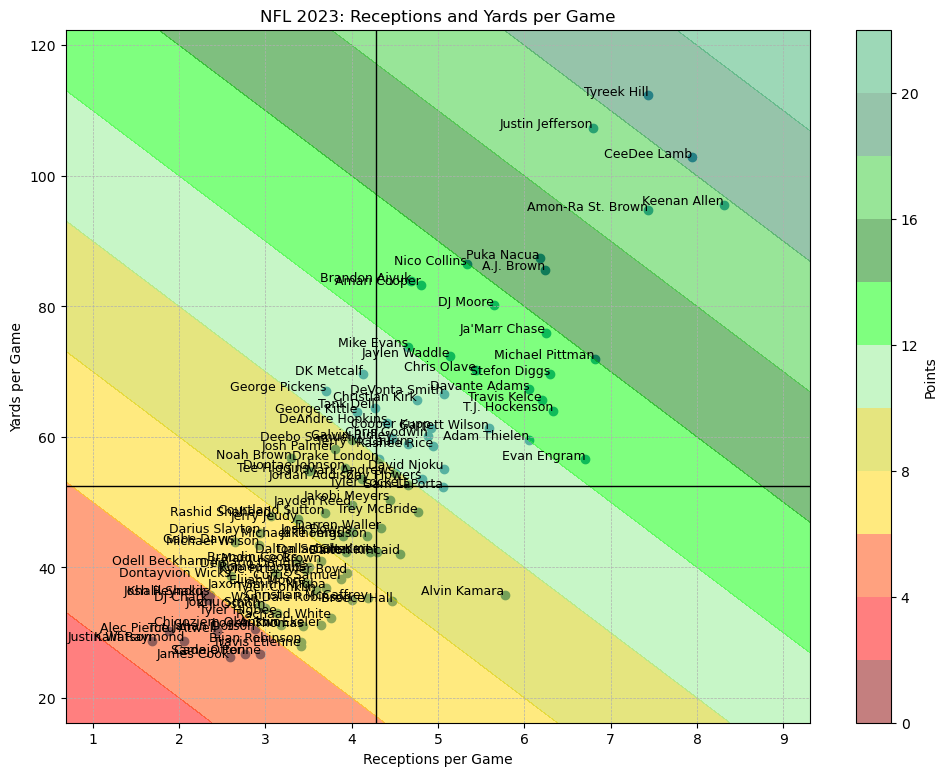

In [122]:
x = np.linspace(rec_df['REC/GP'].min() - 1, rec_df['REC/GP'].max() + 1, 100)
y = np.linspace(rec_df['YDS/G'].min() - 10, rec_df['YDS/G'].max() + 10, 100)
X, Y = np.meshgrid(x, y)
Z = X + (Y * 0.1)

colors = [
    "darkred",
    "#FF0000",  # Pure Red
    "#FF4500",  # OrangeRed, variant of red
    "#FFD700",  # Gold, bright yellow
    "#CCCC00",  # Olive Yellow
    "#90EE90",  # Light Green
    "#00FF00",  # Lime, pure green
    "#008000",  # Green, dark green
    "#32CD32",  # LimeGreen, variant of green
    "seagreen",  # Sea Green
    "#3cb371"
]

fig, ax = plt.subplots(figsize=(12, 9))

plt.scatter(rec_df['REC/GP'], rec_df['YDS/G'])

for index, row in rec_df.iterrows():
    plt.text(row['REC/GP'], row['YDS/G'], row['Player'], fontsize=9, ha='right')


x_mean = rec_df['REC/GP'].mean()
y_mean = rec_df['YDS/G'].mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)

plt.contourf(X, Y, Z, levels=np.arange(0, 24, 2), colors=colors, alpha=0.5)
plt.colorbar(label='Points', orientation='vertical')

ax.set_xlabel('Receptions per Game')
ax.set_ylabel('Yards per Game')
ax.set_title('NFL 2023: Receptions and Yards per Game')
ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

#plt.xlim(total_defense['TYDS/G'].min() - 25, total_defense['TYDS/G'].max() + 25)
plt.ylim(rec_df['YDS/G'].min() - 10, rec_df['YDS/G'].max() + 10)
plt.yticks = np.arange(rec_df['YDS/G'].min() - 10, rec_df['YDS/G'].max() + 10, 10)
#plt.savefig('logos.png', dpi=450)
plt.show()

In [167]:
passing_of = dataframes['passing_of']
rushing_of = dataframes['rushing_of']

In [169]:
total_offense = pd.merge(passing_of, rushing_of, on='Team')

In [172]:
total_offense['TYDS/G'] = (total_offense['Pass Yds'].astype('float') + total_offense['Rush Yds'].astype('float')) / 17
total_offense['TDs/G'] = (total_offense['TD_x'].astype('float') + total_offense['TD_y'].astype('float')) / 17

In [176]:
x = total_offense['TYDS/G']
y = total_offense['TDs/G']
N = len(x)
x_sum = np.sum(x)
y_sum = np.sum(y)
xy_sum = np.sum(x*y)
x2_sum = np.sum(x**2)
y2_sum = np.sum(y**2)

slope = (N*xy_sum - x_sum*y_sum) / (N*x2_sum - x_sum**2)
intercept = (y_sum - slope*x_sum) / N

# Calculate correlation coefficient
r_num = N*xy_sum - x_sum*y_sum
r_den = np.sqrt((N*x2_sum - x_sum**2) * (N*y2_sum - y_sum**2))
r = r_num / r_den

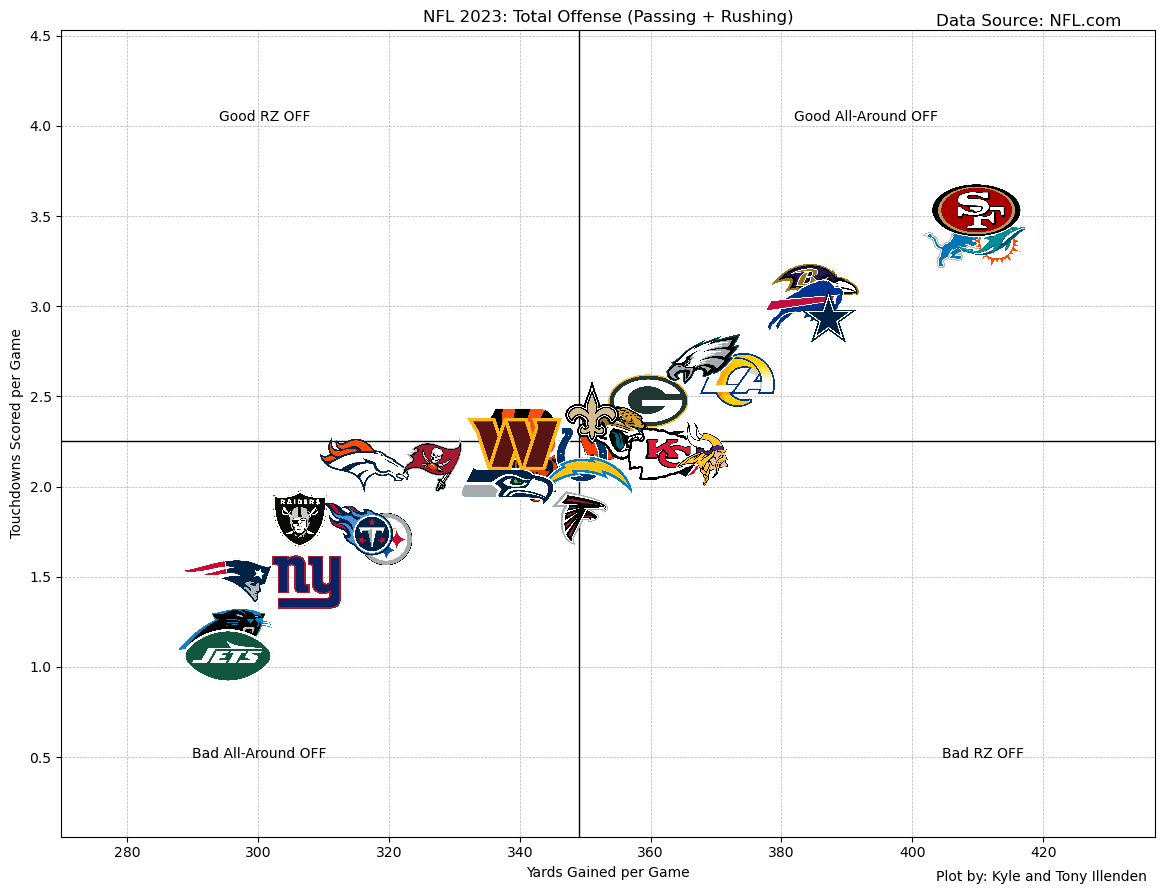

In [204]:
fig, ax = plt.subplots(figsize=(12, 9))

zoom = 0.05

for i, team in enumerate(total_offense['Team']):
    logo_url = get_team_logo(team)
    img = plt.imread(logo_url)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (total_offense['TYDS/G'][i], total_offense['TDs/G'][i]), frameon=False)
    ax.add_artist(ab)

x_mean = total_offense['TYDS/G'].mean()
y_mean = total_offense['TDs/G'].mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)
ax.text(x_mean + 55, total_offense['TDs/G'].max() + 0.5, 'Good All-Around OFF', color='black', horizontalalignment='right')
ax.text(x_mean - 55, total_offense['TDs/G'].max() + 0.5, 'Good RZ OFF', color='black', horizontalalignment='left')
ax.text(total_offense['TYDS/G'].min() - 5, total_offense['TDs/G'].min() - 0.5, 'Bad All-Around OFF', color='black', horizontalalignment='left', verticalalignment='top')
ax.text(total_offense['TYDS/G'].max() + 5, total_offense['TDs/G'].min() - 0.5, 'Bad RZ OFF', color='black', verticalalignment='top', horizontalalignment='right')



ax.set_xlabel('Yards Gained per Game')
ax.set_ylabel('Touchdowns Scored per Game')
ax.set_title('NFL 2023: Total Offense (Passing + Rushing)')
ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')
plt.xlim(total_offense['TYDS/G'].min() - 25, total_offense['TYDS/G'].max() + 25)
plt.ylim(total_offense['TDs/G'].min() - 1, total_offense['TDs/G'].max() + 1)
#plt.savefig('logos.png', dpi=450)
#ax.text(400, 0.25, 'Plot by: Kyle and Tony Illenden', color='black', fontsize=8)
ax.text(0.80, -0.055, 'Plot by: Kyle and Tony Illenden', color='black', fontsize=10, transform=ax.transAxes)
ax.text(0.80, 1.005, 'Data Source: NFL.com', color='black', fontsize=12, transform=ax.transAxes)

plt.tight_layout()
plt.show()

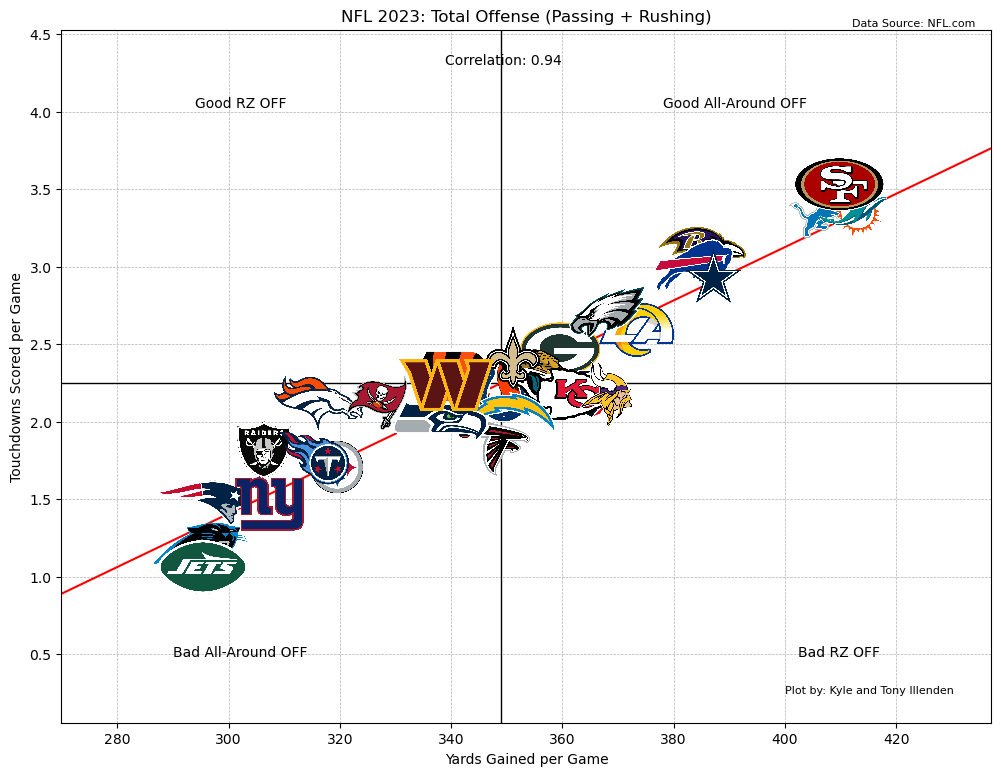

In [189]:
fig, ax = plt.subplots(figsize=(12, 9))

zoom = 0.05

for i, team in enumerate(total_offense['Team']):
    logo_url = get_team_logo(team)
    img = plt.imread(logo_url)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (total_offense['TYDS/G'][i], total_offense['TDs/G'][i]), frameon=False)
    ax.add_artist(ab)


x_mean = total_offense['TYDS/G'].mean()
y_mean = total_offense['TDs/G'].mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)
ax.text(x_mean + 55, total_offense['TDs/G'].max() + 0.5, 'Good All-Around OFF', color='black', horizontalalignment='right')
ax.text(x_mean - 55, total_offense['TDs/G'].max() + 0.5, 'Good RZ OFF', color='black', horizontalalignment='left')
ax.text(total_offense['TYDS/G'].min() - 5, total_offense['TDs/G'].min() - 0.5, 'Bad All-Around OFF', color='black', horizontalalignment='left', verticalalignment='top')
ax.text(total_offense['TYDS/G'].max() + 5, total_offense['TDs/G'].min() - 0.5, 'Bad RZ OFF', color='black', verticalalignment='top', horizontalalignment='right')

x_line = np.array([x.min() - 25, x.max() + 25])
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='red', label=f'Linear Regression\n$r$ = {r:.2f}')

# Display correlation coefficient
ax.text(0.475, 0.95, f'Correlation: {r:.2f}', color='black', horizontalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.85, 1.005, 'Data Source: NFL.com', color='black', fontsize=8, transform=ax.transAxes)

ax.set_xlabel('Yards Gained per Game')
ax.set_ylabel('Touchdowns Scored per Game')
ax.set_title('NFL 2023: Total Offense (Passing + Rushing)')
ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')
plt.xlim(total_offense['TYDS/G'].min() - 25, total_offense['TYDS/G'].max() + 25)
plt.ylim(total_offense['TDs/G'].min() - 1, total_offense['TDs/G'].max() + 1)
#plt.savefig('logos.png', dpi=450)
ax.text(400, 0.25, 'Plot by: Kyle and Tony Illenden', color='black', fontsize=8)

plt.show()

In [168]:
passing_of

,Team,Att,Cmp,Cmp %,Yds/Att,Pass Yds,TD,INT,Rate,1st,1st%,20+,40+,Lng,Sck,SckY
0,ARI,555,355,64.0,6.2,3430,18,12,82.9,173,31.2,38,3,69T,42,286
1,ATL,530,327,61.7,7.1,3775,17,17,80.5,181,34.2,46,10,75,40,251
2,BAL,494,328,66.4,7.9,3881,27,7,102.5,180,36.4,52,9,80T,41,246
3,BUF,579,385,66.5,7.4,4306,29,18,92.2,199,34.4,49,9,81T,24,152
4,CAR,586,350,59.7,5.5,3245,13,10,75.2,150,25.6,31,5,48T,65,504
5,CHI,513,321,62.6,6.7,3421,19,15,82.2,169,32.9,48,5,58,50,325
6,CIN,615,420,68.3,6.9,4257,27,14,93.0,208,33.8,46,10,80,50,362
7,CLE,624,355,56.9,6.4,4011,24,23,73.7,173,27.7,53,15,75,45,318
8,DAL,614,428,69.7,7.6,4660,36,10,104.6,229,37.3,64,7,92T,40,263
9,DEN,513,337,65.7,7.0,3566,28,9,96.7,154,30.0,44,13,60,52,304


In [123]:
schedule_df = pd.read_csv('Schedule.csv')

In [124]:
schedule_df

,TEAM,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,ARI,@WSH,NYG,DAL,@SF,CIN,@LAR,@SEA,BAL,@CLE,ATL,@HOU,LAR,@PIT,BYE,SF,@CHI,@PHI,SEA
1,ATL,CAR,GB,@DET,@JAX,HOU,WSH,@TB,@TEN,MIN,@ARI,BYE,NO,@NYJ,TB,@CAR,IND,@CHI,@NO
2,BAL,HOU,@CIN,IND,@CLE,@PIT,@TEN,DET,@ARI,SEA,CLE,CIN,@LAC,BYE,LAR,@JAX,@SF,MIA,PIT
3,BUF,@NYJ,LV,@WSH,MIA,JAX,NYG,@NE,TB,@CIN,DEN,NYJ,@PHI,BYE,@KC,DAL,@LAC,NE,@MIA
4,CAR,@ATL,NO,@SEA,MIN,@DET,@MIA,BYE,HOU,IND,@CHI,DAL,@TEN,@TB,@NO,ATL,GB,@JAX,TB
5,CHI,GB,@TB,@KC,DEN,@WSH,MIN,LV,@LAC,@NO,CAR,@DET,@MIN,BYE,DET,@CLE,ARI,ATL,@GB
6,CIN,@CLE,BAL,LAR,@TEN,@ARI,SEA,BYE,@SF,BUF,HOU,@BAL,PIT,@JAX,IND,MIN,@PIT,@KC,CLE
7,CLE,CIN,@PIT,TEN,BAL,BYE,SF,@IND,@SEA,ARI,@BAL,PIT,@DEN,@LAR,JAX,CHI,@HOU,NYJ,@CIN
8,DAL,@NYG,NYJ,@ARI,NE,@SF,@LAC,BYE,LAR,@PHI,NYG,@CAR,WSH,SEA,PHI,@BUF,@MIA,DET,@WSH
9,DEN,LV,WSH,@MIA,@CHI,NYJ,@KC,GB,KC,BYE,@BUF,MIN,CLE,@HOU,@LAC,@DET,NE,LAC,@LV


In [143]:
week_number = '5'  # Specify the week number you're interested in
week_5_value = None  # Initialize variable to store the week 5 value

for index, row in schedule_df.iterrows():
    if row['TEAM'] == 'DET' and not pd.isna(row[week_number]):
        week_5_value = row[week_number]
        

In [144]:
week_5_value

'CAR'

In [142]:
last_det_row

TEAM     DET
1        @KC
2        SEA
3        ATL
4        @GB
5        CAR
6        @TB
7       @BAL
8         LV
9        BYE
10      @LAC
11       CHI
12        GB
13       @NO
14      @CHI
15       DEN
16      @MIN
17      @DAL
18       MIN
Name: 10, dtype: object

In [140]:
for index, row in schedule_df.iterrows():
    if row['TEAM'] == 'DET':
        last_det_row = row

if last_det_row is not None:
    print(last_det_row)
else:
    print("No 'DET' team found in the DataFrame.")

TEAM     DET
1        @KC
2        SEA
3        ATL
4        @GB
5        CAR
6        @TB
7       @BAL
8         LV
9        BYE
10      @LAC
11       CHI
12        GB
13       @NO
14      @CHI
15       DEN
16      @MIN
17      @DAL
18       MIN
Name: 10, dtype: object


In [229]:
testing = pd.read_html('https://www.foxsports.com/nfl/dak-prescott-player-game-log?season=2023')

In [235]:
dak_columns = testing[0].columns

In [240]:
dak_data = testing[-1]

In [242]:
dak_data.columns = dak_columns

In [243]:
dak_data

,GAME,GAME.1,GS,COMP,PATT,PCT,PYDS,PAVG,PTD,PASS INT,SCK,SCKYDS,RATT,RYDS,RAVG,RTD,FUM
0,1/14,GB L,-,41,60,68.3,403,6.7,3,2,4,16,6,45,7.5,0,0
1,1/7,@WAS W,-,31,36,86.1,279,7.8,4,1,0,0,0,0,-,0,0
2,12/30,DET W,-,26,38,68.4,345,9.1,2,1,3,22,2,5,2.5,0,1
3,12/24,@MIA L,-,20,32,62.5,253,7.9,2,0,4,11,5,25,5.0,0,1
4,12/17,@BUF L,-,21,34,61.8,134,3.9,0,1,3,28,4,27,6.8,0,0
5,12/10,PHI W,-,24,39,61.5,271,6.9,2,0,3,15,3,11,3.7,0,1
6,11/30,SEA W,-,29,41,70.7,299,7.3,3,0,4,24,7,23,3.3,0,0
7,11/23,WAS W,-,22,32,68.8,331,10.3,4,0,0,0,1,10,10.0,0,0
8,11/19,@CAR W,-,25,38,65.8,189,5.0,2,0,0,0,2,6,3.0,0,0
9,11/12,NYG W,-,26,35,74.3,404,11.5,4,1,0,0,2,17,8.5,1,0


In [250]:
dak_data['PTS'] = (dak_data['PYDS'].astype('float')*0.04) + (dak_data['PTD'].astype('float')*4) + (dak_data['RYDS'].astype('float')*0.1) + (dak_data['RTD'].astype('int')*6) - (dak_data['PASS INT'].astype('float')) - (dak_data['FUM'].astype('float')*2)

In [251]:
dak_data

,GAME,GAME.1,GS,COMP,PATT,PCT,PYDS,PAVG,PTD,PASS INT,SCK,SCKYDS,RATT,RYDS,RAVG,RTD,FUM,PTS
0,1/14,GB L,-,41,60,68.3,403,6.7,3,2,4,16,6,45,7.5,0,0,30.62
1,1/7,@WAS W,-,31,36,86.1,279,7.8,4,1,0,0,0,0,-,0,0,26.16
2,12/30,DET W,-,26,38,68.4,345,9.1,2,1,3,22,2,5,2.5,0,1,19.30
3,12/24,@MIA L,-,20,32,62.5,253,7.9,2,0,4,11,5,25,5.0,0,1,18.62
4,12/17,@BUF L,-,21,34,61.8,134,3.9,0,1,3,28,4,27,6.8,0,0,7.06
5,12/10,PHI W,-,24,39,61.5,271,6.9,2,0,3,15,3,11,3.7,0,1,17.94
6,11/30,SEA W,-,29,41,70.7,299,7.3,3,0,4,24,7,23,3.3,0,0,26.26
7,11/23,WAS W,-,22,32,68.8,331,10.3,4,0,0,0,1,10,10.0,0,0,30.24
8,11/19,@CAR W,-,25,38,65.8,189,5.0,2,0,0,0,2,6,3.0,0,0,16.16
9,11/12,NYG W,-,26,35,74.3,404,11.5,4,1,0,0,2,17,8.5,1,0,38.86


In [252]:
dak_data['RoC'] = dak_data['PTS'].diff() / 1 

In [253]:
dak_data

,GAME,GAME.1,GS,COMP,PATT,PCT,PYDS,PAVG,PTD,PASS INT,SCK,SCKYDS,RATT,RYDS,RAVG,RTD,FUM,PTS,RoC
0,1/14,GB L,-,41,60,68.3,403,6.7,3,2,4,16,6,45,7.5,0,0,30.62,NaN
1,1/7,@WAS W,-,31,36,86.1,279,7.8,4,1,0,0,0,0,-,0,0,26.16,-4.46
2,12/30,DET W,-,26,38,68.4,345,9.1,2,1,3,22,2,5,2.5,0,1,19.30,-6.86
3,12/24,@MIA L,-,20,32,62.5,253,7.9,2,0,4,11,5,25,5.0,0,1,18.62,-0.68
4,12/17,@BUF L,-,21,34,61.8,134,3.9,0,1,3,28,4,27,6.8,0,0,7.06,-11.56
5,12/10,PHI W,-,24,39,61.5,271,6.9,2,0,3,15,3,11,3.7,0,1,17.94,10.88
6,11/30,SEA W,-,29,41,70.7,299,7.3,3,0,4,24,7,23,3.3,0,0,26.26,8.32
7,11/23,WAS W,-,22,32,68.8,331,10.3,4,0,0,0,1,10,10.0,0,0,30.24,3.98
8,11/19,@CAR W,-,25,38,65.8,189,5.0,2,0,0,0,2,6,3.0,0,0,16.16,-14.08
9,11/12,NYG W,-,26,35,74.3,404,11.5,4,1,0,0,2,17,8.5,1,0,38.86,22.70


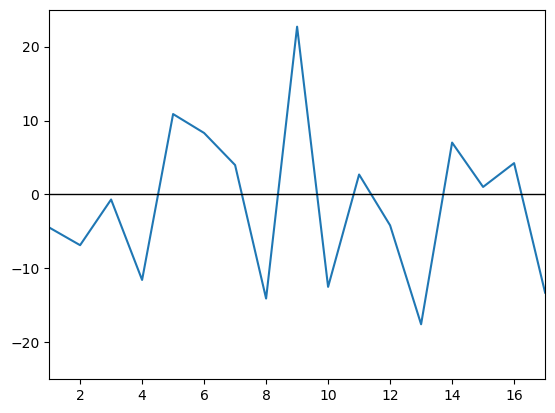

In [260]:
plt.plot(dak_data.index, dak_data['RoC'])
plt.xlim(1, 17)
plt.ylim(-25, 25)
plt.axhline(0, color='black', linestyle='-', linewidth=1)

In [228]:
testing[1]

,1/14,GB L,-,41,60,68.3,403,6.7,3,2,4,16,6,45,7.5,0,0.1
0,1/7,@WAS W,-,31,36,86.1,279,7.8,4,1,0,0,0,0,-,0,0
1,12/30,DET W,-,26,38,68.4,345,9.1,2,1,3,22,2,5,2.5,0,1
2,12/24,@MIA L,-,20,32,62.5,253,7.9,2,0,4,11,5,25,5.0,0,1
3,12/17,@BUF L,-,21,34,61.8,134,3.9,0,1,3,28,4,27,6.8,0,0
4,12/10,PHI W,-,24,39,61.5,271,6.9,2,0,3,15,3,11,3.7,0,1
5,11/30,SEA W,-,29,41,70.7,299,7.3,3,0,4,24,7,23,3.3,0,0
6,11/23,WAS W,-,22,32,68.8,331,10.3,4,0,0,0,1,10,10.0,0,0
7,11/19,@CAR W,-,25,38,65.8,189,5.0,2,0,0,0,2,6,3.0,0,0
8,11/12,NYG W,-,26,35,74.3,404,11.5,4,1,0,0,2,17,8.5,1,0
9,11/5,@PHI L,-,29,44,65.9,374,8.5,3,0,5,41,6,14,2.3,0,1


In [223]:
testing_df = testing[0]

In [224]:
testing_df.columns

Index(['GAME', 'GAME.1', 'GS', 'COMP', 'PATT', 'PCT', 'PYDS', 'PAVG', 'PTD',
       'PASS INT', 'SCK', 'SCKYDS', 'RATT', 'RYDS', 'RAVG', 'RTD', 'FUM'],
      dtype='object')

In [225]:
testing_df

,GAME,GAME.1,GS,COMP,PATT,PCT,PYDS,PAVG,PTD,PASS INT,SCK,SCKYDS,RATT,RYDS,RAVG,RTD,FUM
